In [1]:
!pip install pytorch_lightning
!pip install keras_tuner
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch
import torch.nn as nn
from torchmetrics import PearsonCorrCoef, MeanSquaredError
!pip install colorama
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
import scprep

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.decomposition import TruncatedSVD

!pip install tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.utils import plot_model
import keras_tuner

%cd /home/jovyan/kaggle/working

%cd robust-pca
import r_pca
%cd ..

def delete_columns_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    mask = np.ones(mat.shape[1], dtype=bool)
    mask[indices] = False
    return mat[:,mask]

def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def correlation_score_cols(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    abc = []
    for i in range(y_true.shape[1]):
        temp = np.corrcoef(y_true[:,i], y_pred[:,i])[1, 0]
        abc.append(temp)
        corrsum += temp
    print(corrsum / y_true.shape[1])
    return abc

def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

def negative_pearson_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    vx = y_pred - torch.mean(y_pred,1,keepdim=True)
    vy = y_true - torch.mean(y_true,1,keepdim=True)

    cost = torch.mean(torch.sum(vx * vy,1) / (torch.sqrt(torch.sum(vx ** 2,1)) * torch.sqrt(torch.sum(vy ** 2,1))))

    return - cost

def my_model(n_inputs,n_outputs, reg1, reg2,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    x1 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x0)
    x2 = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x1)
    x3 = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

# Cross-validation
VERBOSE = 2 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 3

def fit(X_train, y_train,meta,loss=negative_correlation_loss):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1=reg1,reg2=reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr

        # We validate the model
        y_pred = model.predict(X_va, batch_size=X_va.shape[0])
        corrscore = correlation_score(y_va, y_pred)

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, corr =  {corrscore:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(corrscore)

        return model

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

  Using cached pytorch_lightning-1.7.7-py3-none-any.whl (708 kB)
  Using cached torchmetrics-0.10.0-py3-none-any.whl (529 kB)
  Using cached pyDeprecate-0.3.2-py3-none-any.whl (10 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.0
    Uninstalling tensorboard-2.9.0:
      Successfully uninstalled tensorboard-2.9.0
  Using cached keras_tuner-1.1.3-py3-none-any.whl (135 kB)
  Using cached kt_legacy-1.0.4-py3-none-any.whl (9.6 kB)
  Using cached tensorflow-2.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB

2022-10-20 20:41:58.184993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 20:41:58.343188: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 20:41:58.381399: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 20:41:59.067720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

/home/jovyan/kaggle/working
/home/jovyan/kaggle/working/robust-pca
/home/jovyan/kaggle/working


In [106]:
scprep.filter.remove_empty_genes(np.vstack([X_train,X_test])).shape

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 21601 and the array at index 1 has size 1

In [115]:
X_test = scipy.sparse.load_npz('./sparse/test_cite_inputs_values.sparse.npz')
X_test = delete_columns_csr(X_test,to_drop)
X_test.shape

(48663, 21601)

In [116]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
X_train = delete_columns_csr(X_train,to_drop)

In [112]:
X_train = delete_columns_csr(X_train,to_drop)

In [ ]:
X_train = scprep.filter.remove_empty_genes(X_train)

In [113]:
X_train.shape

(70988, 21601)

In [89]:
y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
y_train -= y_train.mean(axis=1).reshape(-1, 1)
y_train /= y_train.std(axis=1).reshape(-1, 1)

In [95]:
X_train = X_train.toarray()

In [66]:
data_loader_0 = np.hstack([y_train[:,1],X_train])

In [67]:
data_frame = pd.DataFrame(data_loader_0)

In [8]:
!pip install git+https://github.com/BasisResearch/millipede.git

  Cloning https://github.com/BasisResearch/millipede.git to /tmp/pip-req-build-st8bwfmm
  Running command git clone --filter=blob:none --quiet https://github.com/BasisResearch/millipede.git /tmp/pip-req-build-st8bwfmm
  Resolved https://github.com/BasisResearch/millipede.git to commit ecafe4194e216846600ff4f87dc02f65ce4428e2
  Preparing metadata (setup.py) ... done
  Using cached polyagamma-1.3.2-cp39-cp39-manylinux_2_12_x86_64.manylinux_2_5_x86_64.manylinux1_x86_64.manylinux2010_x86_64.whl (523 kB)
  Created wheel for millipede: filename=millipede-0.1.0-py3-none-any.whl size=33845 sha256=3b87a0c52293a8c0783509d96f60fdc47da982c657ee35218e9f944c18ceba2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-bi8rjx0n/wheels/0a/6b/57/40b20d03468593c7819cb14105caeb501b22dc304ff2f9193c
Successfully built millipede


In [69]:
X_train_pca = np.genfromtxt('./pca64/X_train_64.csv',delimiter = ',')

In [70]:
data_loader_0 = np.hstack([data_loader_0,X_train_pca])

In [71]:
data_frame = pd.DataFrame(data_loader_0)

In [72]:
data_frame.shape

(70988, 21858)

In [73]:
del data_loader_0, X_train,y_train

In [74]:
data_frame.size*4/1024/1024/1024


5.780367940664291

In [75]:
from millipede import NormalLikelihoodVariableSelector
selector = NormalLikelihoodVariableSelector(data_frame.loc[:10000],  # pass in the data
                                            0, # indicate the column of responses
                                            S=1000,        # specify the expected number of covariates to include a priori
                                           device='gpu',
                                           subset_size=1000)

In [76]:
selector.run(T=2000, T_burnin=1000, verbosity='bar', report_frequency=1, streaming=True, seed=None)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [77]:
pd.set_option('display.max_rows', 100)
selector.summary.sort_values(by=['PIP'],ascending=False).iloc[:100]

,PIP,Coefficient,Coefficient StdDev,Conditional Coefficient,Conditional Coefficient StdDev
21605,1.000000,0.001723,0.000804,0.001723,0.000804
16095,0.869618,-0.005794,0.003584,-0.007685,0.001584
11107,0.655650,-0.014475,2.061484,-0.021789,2.529205
17278,0.615665,-0.014055,2.008753,-0.022465,2.539616
21607,0.583251,-0.000673,0.000938,-0.001151,0.000977
9695,0.513235,-0.034276,1.912190,-0.065931,2.651675
7885,0.497594,0.028206,1.840328,0.055871,2.589795
2773,0.440364,0.012374,1.702930,0.027522,2.539579
6003,0.418774,-0.041943,1.665641,-0.099085,2.558968
9356,0.397690,0.019387,1.761053,0.048207,2.776706


In [18]:
data_frame.shape

(70988, 21858)

In [19]:
indices = selector.summary.loc[selector.summary.PIP > 0.5].index

In [20]:
indices

Index([1484, 4484, 6469, 10774, 10919, 11737, 12196, 13042, 16746, 18625,
       19149, 20488],
      dtype='object')

In [21]:
indices + 1

Int64Index([1485, 4485, 6470, 10775, 10920, 11738, 12197, 13043, 16747, 18626,
            19150, 20489],
           dtype='int64')

In [22]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)

In [96]:
def my_model(n_inputs,n_outputs, reg1, reg2,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(16,
              activation=activation,
             )(inputs)
    x1 = Dense(16,
              activation=activation,
             )(x0)
    x2 = Dense(16,
              activation=activation,
             )(x1)
    x3 = Dense(16,
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs,
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

# Cross-validation
VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 3

def fit(X_train, y_train,meta,loss=tf.keras.losses.MeanSquaredError()):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                              patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                          patience=12, 
                          verbose=0,
                          mode="min", 
                          restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

        # Construct and compile the model
        model = my_model(n_inputs=X_train.shape[1],n_outputs=y_train.shape[1],reg1 = reg1,reg2 = reg2,loss = loss)

        # Train the model
        history = model.fit(X_tr, y_tr, 
                            validation_data=(X_va, y_va), 
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=callbacks)
        del X_tr, y_tr

        # We validate the model
        y_pred = model.predict(X_va, batch_size=X_va.shape[0])
        mse = tf.keras.losses.MeanSquaredError()(y_va, y_pred)
        #corrscore = correlation_score(y_va, y_pred)

        print(f"Fold {fold}: {es.stopped_epoch:3} epochs, mse =  {mse:.5f}")
        del es, X_va#, y_va, y_va_pred
        score_list.append(mse)

        return model

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
    
LR_START = 0.01
BATCH_SIZE = 256

best_var = []
for i in np.arange(2,10,1):
    print(i)
    data_loader_0 = np.hstack([y_train[:,i],X_train,X_train_pca])
    data_frame = pd.DataFrame(data_loader_0)

    del data_loader_0

    from millipede import NormalLikelihoodVariableSelector
    selector = NormalLikelihoodVariableSelector(data_frame.loc[:10000],  # pass in the data
                                                0, # indicate the column of responses
                                                S=1000,        # specify the expected number of covariates to include a priori
                                               device='gpu',
                                               subset_size=1000)

    selector.run(T=2000, T_burnin=1000, verbosity='bar', report_frequency=1, streaming=True, seed=None)

    indices = list(selector.summary.loc[selector.summary.PIP > 0.5].index)    
    option_a = fit(data_frame.to_numpy()[:,indices],data_frame.to_numpy()[:,0].reshape(-1,1),meta)
    indices = list(selector.summary.loc[selector.summary.PIP > 0.1].index)    
    option_b = fit(data_frame.to_numpy()[:,indices],data_frame.to_numpy()[:,0].reshape(-1,1),meta)
    indices = list(selector.summary.loc[selector.summary.PIP > 0.01].index)    
    option_c = fit(data_frame.to_numpy()[:,indices],data_frame.to_numpy()[:,0].reshape(-1,1),meta)
    indices = list(selector.summary.loc[selector.summary.PIP > 0.01].index)    
    option_d = fit(data_frame.to_numpy()[:,indices],data_frame.to_numpy()[:,0].reshape(-1,1),meta)
    option_e = fit(data_frame.to_numpy()[:,-256:],data_frame.to_numpy()[:,0].reshape(-1,1),meta)
    options = [option_a,option_b,option_c,option_d,option_e]
    match np.argmax(options):
        case 0:
             best_var.append(0.5)
        case 1:
             best_var.append(0.1)
        case 2:
             best_var.append(0.01)
        case 3:
             best_var.append(0.001)
        case 4:
             best_var.append(0)
        

2


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
Fold 0:  42 epochs, mse =  0.06772
1/1 [==============================] - 0s 76ms/step
Fold 0:  13 epochs, mse =  0.06809
1/1 [==============================] - 0s 93ms/step
Fold 0:  12 epochs, mse =  0.06840
1/1 [==============================] - 0s 80ms/step
Fold 0:  35 epochs, mse =  0.06979
3


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
Fold 0:  35 epochs, mse =  0.29303
1/1 [==============================] - 0s 77ms/step
Fold 0:  12 epochs, mse =  0.29216
1/1 [==============================] - 0s 93ms/step
Fold 0:  13 epochs, mse =  0.28476
1/1 [==============================] - 0s 79ms/step
Fold 0:  21 epochs, mse =  0.27842
4


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
Fold 0:  26 epochs, mse =  0.16899
1/1 [==============================] - 0s 78ms/step
Fold 0:  24 epochs, mse =  0.16871
1/1 [==============================] - 0s 91ms/step
Fold 0:  15 epochs, mse =  0.16813
1/1 [==============================] - 0s 80ms/step
Fold 0:  28 epochs, mse =  0.16770
5


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
Fold 0:  31 epochs, mse =  0.54235
1/1 [==============================] - 0s 79ms/step
Fold 0:  18 epochs, mse =  0.54244
1/1 [==============================] - 0s 93ms/step
Fold 0:  13 epochs, mse =  0.55474
1/1 [==============================] - 0s 81ms/step
Fold 0:  27 epochs, mse =  0.54440
6


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step
Fold 0:  17 epochs, mse =  0.62653
1/1 [==============================] - 0s 80ms/step
Fold 0:  13 epochs, mse =  0.61729
1/1 [==============================] - 0s 94ms/step
Fold 0:  13 epochs, mse =  0.63788
1/1 [==============================] - 0s 83ms/step
Fold 0:  14 epochs, mse =  0.65025
7


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
Fold 0:  18 epochs, mse =  0.10116
1/1 [==============================] - 0s 79ms/step
Fold 0:  19 epochs, mse =  0.10262
1/1 [==============================] - 0s 97ms/step
Fold 0:  13 epochs, mse =  0.10258
1/1 [==============================] - 0s 82ms/step
Fold 0:  23 epochs, mse =  0.10255
8


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
Fold 0:  25 epochs, mse =  0.06221
1/1 [==============================] - 0s 79ms/step
Fold 0:  21 epochs, mse =  0.06229
1/1 [==============================] - 0s 96ms/step
Fold 0:  13 epochs, mse =  0.06193
1/1 [==============================] - 0s 82ms/step
Fold 0:  22 epochs, mse =  0.07043
9


  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step
Fold 0:  43 epochs, mse =  0.10609
1/1 [==============================] - 0s 79ms/step
Fold 0:  17 epochs, mse =  0.10650
1/1 [==============================] - 0s 95ms/step
Fold 0:  12 epochs, mse =  0.10703
1/1 [==============================] - 0s 81ms/step
Fold 0:  17 epochs, mse =  0.10719


0th column
indices: mse = 0.12761, len = 12
256 pca: mse = 0.12938
0.1 indices: mse = 0.12721, len = 184
0.01 indices: mse = 0.12669, len = 834
0.001 indices: mse = 0.12839, len = 1165

In [ ]:
1st column
indices: mse = 0.06724, len = 6
256 pca: mse = 0.06854
0.1 indices: mse = 0.06735, len = 142
0.01 indices: mse = 0.06687, len = 836
0.001 indices: mse = 0.06681, len = 1146

In [86]:
indices = list(selector.summary.loc[selector.summary.PIP > 0.001].index)    
len(indices)

1146

In [11]:
abc = [[-0.3777119 ],[-0.3709885 ],[-0.2560002 ]]
np.hstack([abc,abc])

array([[-0.3777119, -0.3777119],
       [-0.3709885, -0.3709885],
       [-0.2560002, -0.2560002]])

In [15]:
abc = {0: [],1: [1,2,3], 2: [4,5]}

In [26]:
np.save('./temp/temp.csv',abc,allow_pickle=True)

In [46]:
np.save('./temp/temp.npy', [[],[1,2],[1,2,3]])
np.load('./temp/temp.npy',allow_pickle=True)

array([list([]), list([1, 2]), list([1, 2, 3])], dtype=object)

In [29]:
np.savetxt('./temp/temp.csv',[[],[1,2],[1,2,3]],fmt='%s')

In [31]:
aab = np.genfromtxt('./temp/temp.csv',fmt='%s')
aab

TypeError: genfromtxt() got an unexpected keyword argument 'fmt'

In [27]:
aab = np.load('./temp/temp.csv',allow_pickle=True)
aab

OSError: Failed to interpret file './temp/temp.csv' as a pickle

In [17]:
def my_model(n_inputs,n_outputs,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(16,
              activation=activation,
             )(inputs)
    x1 = Dense(16,
              activation=activation,
             )(x0)
    x2 = Dense(16,
              activation=activation,
             )(x1)
    x3 = Dense(16,
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs,
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

# best_hp = keras_tuner.HyperParameters()
# best_hp.values = {'reg1': 1e-06,
#                   'reg2': 1.3528e-07,
#                   'units1': 256,
#                   'units2': 320,
#                   'units3': 256,
#                   'units4': 320,
#                   'do1': 0.1,
#                   'do2': 0.2,
#                   'do3': 0.2,
#                   'do4': 0.1,
#                   'do5': 0.1,
#                   'lr': 0.01,
#                  }

# def my_model(hp,n_inputs,n_outputs, loss):
#     """Sequential neural network
    
#     Returns a compiled instance of tensorflow.keras.models.Model.
#     """
#     activation = hp.Choice('act',['swish','selu'])
#     reg1 = hp.Float("reg1", min_value=1e-10, max_value=1e-6, sampling="log")
#     reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-6, sampling="log")
    
#     inputs = Input(shape=(n_inputs, ))
#     x0 = Dense(hp.Choice('units1', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(inputs)
#     do1 = Dropout(hp.Choice('do1', [0.1]))(x0)
#     x1 = Dense(hp.Choice('units2', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do1)
#     do2 = Dropout(hp.Choice('do2', [0.2]))(x1)
#     x2 = Dense(hp.Choice('units3', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do2)
#     do3 = Dropout(hp.Choice('do3', [0.2]))(x2)
#     x3 = Dense(hp.Choice('units4', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do3)
#     do4 = Dropout(hp.Choice('do4', [0.1]))(x3)
#     x = Concatenate()([x0, x1, x2, x3])
#     do5 = Dropout(hp.Choice('do5', [0.1]))(x)
#     x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
#               #activation=activation,
#              )(do5)
#     regressor = Model(inputs, x)
#     regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', [0.1])),
#                       metrics=[loss],
#                       loss=loss
#                      )
    
#     return regressor

def eval_model(X_tr,y_tr,X_va,y_va,loss=tf.keras.losses.MeanSquaredError()):
        
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                          patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                      patience=12, 
                      verbose=0,
                      mode="min", 
                      restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    # Construct and compile the model
    model = my_model(n_inputs=X_tr.shape[1],n_outputs=1,loss = loss)

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    
    # We validate the model
    y_pred = model.predict(X_va, batch_size=X_va.shape[0])
    mse = tf.keras.losses.MeanSquaredError()(y_va, y_pred)
    #corrscore = correlation_score(y_va, y_pred)

    print(f"{es.stopped_epoch:3} epochs, mse =  {mse:.5f}")

    return mse, model

# Cross-validation
VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 60
N_SPLITS = 3
LR_START = 0.01
BATCH_SIZE = 256

def fit(X_train, y_train, X_test, meta):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]
        
        best_var = []
        indices_list = []
        i_start = 0
        i_stop = 140
        for i in np.arange(i_start,i_stop,1):
            print(i)
            data_loader_0 = np.hstack([y_tr[:,i],X_tr])
            data_frame = pd.DataFrame(data_loader_0)
            del data_loader_0
            
            from millipede import NormalLikelihoodVariableSelector
            selector = NormalLikelihoodVariableSelector(data_frame.loc[:10000],  # pass in the data
                                                        0, # indicate the column of responses
                                                        S=1000,        # specify the expected number of covariates to include a priori
                                                       device='gpu',
                                                       subset_size=1000)
            selector.run(T=1000, T_burnin=500, verbosity='bar', report_frequency=1, streaming=True, seed=None)
            selector.summary.to_csv('./temp/selector_' + str(i),index=False)
            indices = list(selector.summary.loc[selector.summary.PIP > 0.5].index)    
            option_a, model_a = eval_model(X_tr[:,indices],y_tr[:,i],X_va[:,indices],y_va[:,i])
            indices = list(selector.summary.loc[selector.summary.PIP > 0.1].index)    
            option_b, model_b = eval_model(X_tr[:,indices],y_tr[:,i],X_va[:,indices],y_va[:,i])
            indices = list(selector.summary.loc[selector.summary.PIP > 0.01].index)    
            option_c, model_c = eval_model(X_tr[:,indices],y_tr[:,i],X_va[:,indices],y_va[:,i])
            indices = list(selector.summary.loc[selector.summary.PIP > 0.001].index)    
            option_d, model_d = eval_model(X_tr[:,indices],y_tr[:,i],X_va[:,indices],y_va[:,i])
            option_e, model_e = eval_model(X_tr[:,-256:],y_tr[:,i],X_va[:,-256:],y_va[:,i])
            options = [option_a,option_b,option_c,option_d,option_e]
            if np.argmin(options) == 0:
                best_var.append(0.5)
                model = model_a
            elif np.argmin(options) == 1:
                best_var.append(0.1)
                model = model_b
            elif np.argmin(options) == 2:
                best_var.append(0.01)
                model = model_c
            elif np.argmin(options) == 3:
                best_var.append(0.001)
                model = model_d
            elif np.argmin(options) == 4:
                best_var.append(0)
                model = model_e    
            else:
                raise
            print(best_var)
            if best_var[-1] != 0:
                indices = list(selector.summary.loc[selector.summary.PIP > best_var[-1]].index)    
                indices_list.append(indices)
                if 'y_pred' in locals():
                    y_pred = np.hstack([y_pred,model.predict(X_test[:,indices])])
                    y_va_pred = np.hstack([y_va_pred,model.predict(X_va[:,indices])])
                else:
                    y_pred = model.predict(X_test[:,indices])
                    y_va_pred = model.predict(X_va[:,indices])
            else:
                indices_list.append([])
                if 'y_pred' in locals():
                    y_pred = np.hstack([y_pred,model.predict(X_test[:,-256:])])
                    y_va_pred = np.hstack([y_va_pred,model.predict(X_va[:,-256:])])
                else:
                    y_pred = model.predict(X_test[:,-256:])
                    y_va_pred = model.predict(X_va[:,-256:])

            if i % 10 == 9:
                np.savetxt('./temp/y_pred_save_'+str(i)+'.csv',y_pred,delimiter=',')
                np.savetxt('./temp/indices_save_'+str(i)+'.csv',best_var,delimiter=',')
                np.save('./temp/best_var_save_'+str(i)+'.npy', indices_list)

        corrscore = correlation_score(y_va[:,i_start:i_stop], y_va_pred)
        print(f"Correlation =  {corrscore:.5f}")
        return indices_list, best_var, y_pred
    # Show overall score
#    print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

gc.collect()
indices_list, best_var, y_pred = fit(X_train_mod, y_train, X_test_mod, meta)

np.savetxt('./temp/y_pred_save_'+str(140)+'.csv',y_pred,delimiter=',')
np.savetxt('./temp/indices_save_'+str(140)+'.csv',best_var,delimiter=',')
np.save('./temp/best_var_save_'+str(140)+'.npy', indices_list)

0


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step
 25 epochs, mse =  0.13179
1/1 [==============================] - 0s 78ms/step
 16 epochs, mse =  0.13225
1/1 [==============================] - 0s 92ms/step
 16 epochs, mse =  0.12963
1/1 [==============================] - 0s 99ms/step
 12 epochs, mse =  0.13145
1/1 [==============================] - 0s 80ms/step
 23 epochs, mse =  0.13472
[0.01]
776/776 [==============================] - 1s 2ms/step
1


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 54 epochs, mse =  0.06756
1/1 [==============================] - 0s 74ms/step
 19 epochs, mse =  0.06757
1/1 [==============================] - 0s 86ms/step
 15 epochs, mse =  0.06675
1/1 [==============================] - 0s 95ms/step
 15 epochs, mse =  0.06720
1/1 [==============================] - 0s 77ms/step
 23 epochs, mse =  0.06800
[0.01, 0.01]
776/776 [==============================] - 1s 2ms/step
2


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
 31 epochs, mse =  0.06962
1/1 [==============================] - 0s 72ms/step
 19 epochs, mse =  0.06945
1/1 [==============================] - 0s 85ms/step
 24 epochs, mse =  0.06859
1/1 [==============================] - 0s 96ms/step
 26 epochs, mse =  0.06866
1/1 [==============================] - 0s 87ms/step
 19 epochs, mse =  0.07117
[0.01, 0.01, 0.01]
776/776 [==============================] - 2s 2ms/step
3


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 93ms/step
 21 epochs, mse =  0.30657
1/1 [==============================] - 0s 81ms/step
 17 epochs, mse =  0.30396
1/1 [==============================] - 0s 88ms/step
 14 epochs, mse =  0.29795
1/1 [==============================] - 0s 98ms/step
 16 epochs, mse =  0.29701
1/1 [==============================] - 0s 77ms/step
 19 epochs, mse =  0.28318
[0.01, 0.01, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
4


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
 17 epochs, mse =  0.24523
1/1 [==============================] - 0s 75ms/step
 22 epochs, mse =  0.21974
1/1 [==============================] - 0s 87ms/step
 22 epochs, mse =  0.19758
1/1 [==============================] - 0s 95ms/step
 22 epochs, mse =  0.19366
1/1 [==============================] - 0s 77ms/step
 21 epochs, mse =  0.16846
[0.01, 0.01, 0.01, 0, 0]
776/776 [==============================] - 1s 2ms/step
5


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
 20 epochs, mse =  0.64481
1/1 [==============================] - 0s 72ms/step
 18 epochs, mse =  0.63224
1/1 [==============================] - 0s 87ms/step
 21 epochs, mse =  0.58299
1/1 [==============================] - 0s 172ms/step
 17 epochs, mse =  0.57611
1/1 [==============================] - 0s 78ms/step
 23 epochs, mse =  0.54516
[0.01, 0.01, 0.01, 0, 0, 0]
776/776 [==============================] - 1s 2ms/step
6


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step
 29 epochs, mse =  0.78029
1/1 [==============================] - 0s 86ms/step
 17 epochs, mse =  0.76662
1/1 [==============================] - 0s 94ms/step
 16 epochs, mse =  0.71425
1/1 [==============================] - 0s 100ms/step
 14 epochs, mse =  0.70703
1/1 [==============================] - 0s 78ms/step
 17 epochs, mse =  0.65760
[0.01, 0.01, 0.01, 0, 0, 0, 0]
776/776 [==============================] - 1s 2ms/step
7


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
 13 epochs, mse =  0.10970
1/1 [==============================] - 0s 79ms/step
 23 epochs, mse =  0.10925
1/1 [==============================] - 0s 88ms/step
 18 epochs, mse =  0.10503
1/1 [==============================] - 0s 96ms/step
 13 epochs, mse =  0.11082
1/1 [==============================] - 0s 75ms/step
 18 epochs, mse =  0.10738
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01]
776/776 [==============================] - 1s 2ms/step
8


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 33 epochs, mse =  0.06477
1/1 [==============================] - 0s 75ms/step
 28 epochs, mse =  0.06283
1/1 [==============================] - 0s 92ms/step
 39 epochs, mse =  0.06497
1/1 [==============================] - 0s 97ms/step
 26 epochs, mse =  0.06606
1/1 [==============================] - 0s 78ms/step
  0 epochs, mse =  0.06171
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
9


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 16 epochs, mse =  0.11462
1/1 [==============================] - 0s 73ms/step
 18 epochs, mse =  0.11097
1/1 [==============================] - 0s 99ms/step
 15 epochs, mse =  0.10664
1/1 [==============================] - 0s 137ms/step
 21 epochs, mse =  0.10687
1/1 [==============================] - 0s 76ms/step
  0 epochs, mse =  0.10869
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01]
776/776 [==============================] - 1s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


10


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
 18 epochs, mse =  0.07531
1/1 [==============================] - 0s 86ms/step
 14 epochs, mse =  0.07496
1/1 [==============================] - 0s 94ms/step
 20 epochs, mse =  0.07485
1/1 [==============================] - 0s 98ms/step
 14 epochs, mse =  0.07494
1/1 [==============================] - 0s 79ms/step
 28 epochs, mse =  0.07734
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01]
776/776 [==============================] - 1s 2ms/step
11


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
 22 epochs, mse =  0.12438
1/1 [==============================] - 0s 77ms/step
 12 epochs, mse =  0.12498
1/1 [==============================] - 0s 87ms/step
 13 epochs, mse =  0.12414
1/1 [==============================] - 0s 96ms/step
 15 epochs, mse =  0.12519
1/1 [==============================] - 0s 78ms/step
 24 epochs, mse =  0.12741
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01]
776/776 [==============================] - 1s 2ms/step
12


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
 28 epochs, mse =  0.07417
1/1 [==============================] - 0s 73ms/step
 20 epochs, mse =  0.07451
1/1 [==============================] - 0s 88ms/step
 20 epochs, mse =  0.07465
1/1 [==============================] - 0s 97ms/step
 16 epochs, mse =  0.07611
1/1 [==============================] - 0s 94ms/step
 22 epochs, mse =  0.07769
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5]
776/776 [==============================] - 1s 2ms/step
13


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 20 epochs, mse =  0.11275
1/1 [==============================] - 0s 73ms/step
 12 epochs, mse =  0.11247
1/1 [==============================] - 0s 89ms/step
 17 epochs, mse =  0.11208
1/1 [==============================] - 0s 139ms/step
 18 epochs, mse =  0.10918
1/1 [==============================] - 0s 90ms/step
 29 epochs, mse =  0.10951
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001]
776/776 [==============================] - 1s 2ms/step
14


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step
 35 epochs, mse =  1.29811
1/1 [==============================] - 0s 78ms/step
 22 epochs, mse =  0.35255
1/1 [==============================] - 0s 75ms/step
 20 epochs, mse =  0.33804
1/1 [==============================] - 0s 88ms/step
 13 epochs, mse =  0.32943
1/1 [==============================] - 0s 96ms/step
 14 epochs, mse =  0.33430
1/1 [==============================] - 0s 78ms/step
 15 epochs, mse =  0.32325
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0]
776/776 [==============================] - 1s 2ms/step
16


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 31 epochs, mse =  0.47807
1/1 [==============================] - 0s 74ms/step
 31 epochs, mse =  0.45117
1/1 [==============================] - 0s 86ms/step
 29 epochs, mse =  0.45585
1/1 [==============================] - 0s 97ms/step
 47 epochs, mse =  0.43494
1/1 [==============================] - 0s 77ms/step
 13 epochs, mse =  0.42477
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0]
776/776 [==============================] - 1s 2ms/step
17


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 22 epochs, mse =  0.36423
1/1 [==============================] - 0s 76ms/step
 16 epochs, mse =  0.33033
1/1 [==============================] - 0s 87ms/step
 16 epochs, mse =  0.29971
1/1 [==============================] - 0s 96ms/step
 12 epochs, mse =  0.62584
1/1 [==============================] - 0s 102ms/step
 34 epochs, mse =  0.22511
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0]
776/776 [==============================] - 1s 2ms/step
18


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step
 23 epochs, mse =  0.44188
1/1 [==============================] - 0s 83ms/step
 23 epochs, mse =  0.40143
1/1 [==============================] - 0s 93ms/step
 15 epochs, mse =  0.36777
1/1 [==============================] - 0s 101ms/step
 15 epochs, mse =  0.33989
1/1 [==============================] - 0s 80ms/step
 19 epochs, mse =  0.37916
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
19


  0%|          | 0/1500 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 72ms/step
 27 epochs, mse =  0.05674
1/1 [==============================] - 0s 73ms/step
 15 epochs, mse =  0.05671
1/1 [==============================] - 0s 87ms/step
 20 epochs, mse =  0.05702
1/1 [==============================] - 0s 92ms/step
 14 epochs, mse =  0.05664
1/1 [==============================] - 0s 75ms/step
 22 epochs, mse =  0.05751
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
30


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step
 34 epochs, mse =  0.05987
1/1 [==============================] - 0s 72ms/step
 19 epochs, mse =  0.05994
1/1 [==============================] - 0s 88ms/step
 13 epochs, mse =  0.06013
1/1 [==============================] - 0s 137ms/step
 19 epochs, mse =  0.06031
1/1 [==============================] - 0s 90ms/step
 27 epochs, mse =  0.06959
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5]
776/776 [==============================] - 1s 2ms/step
31


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 87ms/step
 38 epochs, mse =  0.09295
1/1 [==============================] - 0s 84ms/step
 18 epochs, mse =  0.09335
1/1 [==============================] - 0s 96ms/step
 16 epochs, mse =  0.09217
1/1 [==============================] - 0s 104ms/step
 26 epochs, mse =  0.09233
1/1 [==============================] - 0s 83ms/step
 26 epochs, mse =  0.09293
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01]
776/776 [==============================] - 1s 2ms/step
32


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 22 epochs, mse =  0.07483
1/1 [==============================] - 0s 90ms/step
 16 epochs, mse =  0.07542
1/1 [==============================] - 0s 92ms/step
 15 epochs, mse =  0.07468
1/1 [==============================] - 0s 99ms/step
 18 epochs, mse =  0.07560
1/1 [==============================] - 0s 80ms/step
 16 epochs, mse =  0.07681
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01]
776/776 [==============================] - 1s 2ms/step
33


  0%|          | 0/1500 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 76ms/step
 26 epochs, mse =  0.90710
1/1 [==============================] - 0s 74ms/step
 30 epochs, mse =  0.76425
1/1 [==============================] - 0s 86ms/step
 20 epochs, mse =  0.79487
1/1 [==============================] - 0s 97ms/step
 19 epochs, mse =  0.69436
1/1 [==============================] - 0s 77ms/step
 29 epochs, mse =  0.82639
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001]
776/776 [==============================] - 1s 2ms/step
44


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step
 30 epochs, mse =  0.07450
1/1 [==============================] - 0s 72ms/step
 21 epochs, mse =  0.07411
1/1 [==============================] - 0s 87ms/step
 16 epochs, mse =  0.07284
1/1 [==============================] - 0s 114ms/step
 23 epochs, mse =  0.07285
1/1 [==============================] - 0s 92ms/step
 24 epochs, mse =  0.07487
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01]
776/776 [==============================] - 1s 2ms/step
45


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step
 53 epochs, mse =  0.06472
1/1 [==============================] - 0s 84ms/step
 18 epochs, mse =  0.06485
1/1 [==============================] - 0s 96ms/step
 16 epochs, mse =  0.06470
1/1 [==============================] - 0s 101ms/step
 20 epochs, mse =  0.06449
1/1 [==============================] - 0s 84ms/step
 17 epochs, mse =  0.06600
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001]
776/776 [==============================] - 1s 2ms/step
46


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step
 23 epochs, mse =  0.17246
1/1 [==============================] - 0s 80ms/step
 15 epochs, mse =  0.16925
1/1 [==============================] - 0s 89ms/step
 17 epochs, mse =  0.15760
1/1 [==============================] - 0s 97ms/step
 18 epochs, mse =  0.15730
1/1 [==============================] - 0s 78ms/step
 17 epochs, mse =  0.15314
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0]
776/776 [==============================] - 1s 2ms/step
47


  0%|          | 0/1500 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 78ms/step
 16 epochs, mse =  0.07744
1/1 [==============================] - 0s 91ms/step
 21 epochs, mse =  0.07737
1/1 [==============================] - 0s 98ms/step
 21 epochs, mse =  0.07736
1/1 [==============================] - 0s 80ms/step
 15 epochs, mse =  0.07756
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001]
776/776 [==============================] - 1s 2ms/step
52


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 16 epochs, mse =  0.16700
1/1 [==============================] - 0s 79ms/step
 19 epochs, mse =  0.15244
1/1 [==============================] - 0s 87ms/step
 19 epochs, mse =  0.16354
1/1 [==============================] - 0s 94ms/step
 25 epochs, mse =  0.16654
1/1 [==============================] - 0s 91ms/step
 30 epochs, mse =  0.14564
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0]
776/776 [==============================] - 1s 2ms/step
53


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 18 epochs, mse =  0.10179
1/1 [==============================] - 0s 74ms/step
 15 epochs, mse =  0.10232
1/1 [==============================] - 0s 85ms/step
 14 epochs, mse =  0.10298
1/1 [==============================] - 0s 95ms/step
 12 epochs, mse =  0.10181
1/1 [==============================] - 0s 75ms/step
 31 epochs, mse =  0.10832
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5]
776/776 [==============================] - 1s 2ms/step
54


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step
 12 epochs, mse =  0.13508
1/1 [==============================] - 0s 73ms/step
 13 epochs, mse =  0.13230
1/1 [==============================] - 0s 86ms/step
 14 epochs, mse =  0.12520
1/1 [==============================] - 0s 111ms/step
 16 epochs, mse =  0.12348
1/1 [==============================] - 0s 92ms/step
 14 epochs, mse =  0.12025
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0]
776/776 [==============================] - 1s 2ms/step
55


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step
 20 epochs, mse =  0.10321
1/1 [==============================] - 0s 90ms/step
 19 epochs, mse =  0.10107
1/1 [==============================] - 0s 94ms/step
 19 epochs, mse =  0.10924
1/1 [==============================] - 0s 102ms/step
 15 epochs, mse =  0.09549
1/1 [==============================] - 0s 85ms/step
 27 epochs, mse =  0.09517
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0]
776/776 [==============================] - 1s 2ms/step
56


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step
 33 epochs, mse =  0.06857
1/1 [==============================] - 0s 76ms/step
 17 epochs, mse =  0.06853
1/1 [==============================] - 0s 89ms/step
 17 epochs, mse =  0.06790
1/1 [==============================] - 0s 94ms/step
 17 epochs, mse =  0.06854
1/1 [==============================] - 0s 80ms/step
 32 epochs, mse =  0.07068
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01]
776/776 [==============================] - 1s 2ms/step
57


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
 29 epochs, mse =  0.30424
1/1 [==============================] - 0s 77ms/step
 29 epochs, mse =  0.30460
1/1 [==============================] - 0s 88ms/step
 19 epochs, mse =  0.28926
1/1 [==============================] - 0s 99ms/step
 12 epochs, mse =  0.41314
1/1 [==============================] - 0s 78ms/step
 18 epochs, mse =  0.25937
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
58


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 21 epochs, mse =  0.10403
1/1 [==============================] - 0s 73ms/step
 12 epochs, mse =  0.10410
1/1 [==============================] - 0s 87ms/step
 19 epochs, mse =  0.10367
1/1 [==============================] - 0s 93ms/step
 12 epochs, mse =  0.10368
1/1 [==============================] - 0s 78ms/step
 36 epochs, mse =  0.11397
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01]
776/776 [==============================] - 1s 2ms/step
59


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
 32 epochs, mse =  0.10668
1/1 [==============================] - 0s 73ms/step
 17 epochs, mse =  0.10675
1/1 [==============================] - 0s 87ms/step
 14 epochs, mse =  0.10660
1/1 [==============================] - 0s 94ms/step
 14 epochs, mse =  0.10607
1/1 [==============================] - 0s 92ms/step
 19 epochs, mse =  0.11568
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001]
776/776 [==============================] - 1s 2ms/step
60


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
 31 epochs, mse =  0.12536
1/1 [==============================] - 0s 86ms/step
 14 epochs, mse =  0.12327
1/1 [==============================] - 0s 97ms/step
 15 epochs, mse =  0.11872
1/1 [==============================] - 0s 105ms/step
 15 epochs, mse =  0.11510
1/1 [==============================] - 0s 84ms/step
 26 epochs, mse =  0.12292
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001]
776/776 [==============================] - 1s 2ms/step
61


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step
 45 epochs, mse =  0.05696
1/1 [==============================] - 0s 84ms/step
 27 epochs, mse =  0.05617
1/1 [==============================] - 0s 91ms/step
 29 epochs, mse =  0.05582
1/1 [==============================] - 0s 98ms/step
 14 epochs, mse =  0.05501
1/1 [==============================] - 0s 79ms/step
 23 epochs, mse =  0.05376
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0]
776/776 [==============================] - 1s 2ms/step
62


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step
 25 epochs, mse =  0.06601
1/1 [==============================] - 0s 77ms/step
 18 epochs, mse =  0.06410
1/1 [==============================] - 0s 89ms/step
 19 epochs, mse =  0.06257
1/1 [==============================] - 0s 96ms/step
 19 epochs, mse =  0.06207
1/1 [==============================] - 0s 78ms/step
 25 epochs, mse =  0.06237
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
63


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 59 epochs, mse =  0.05787
1/1 [==============================] - 0s 75ms/step
 22 epochs, mse =  0.05790
1/1 [==============================] - 0s 88ms/step
 19 epochs, mse =  0.05695
1/1 [==============================] - 0s 100ms/step
 19 epochs, mse =  0.05759
1/1 [==============================] - 0s 80ms/step
 28 epochs, mse =  0.05876
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01]
776/776 [==============================] - 1s 2ms/step
64


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 30 epochs, mse =  0.14381
1/1 [==============================] - 0s 72ms/step
 16 epochs, mse =  0.14077
1/1 [==============================] - 0s 85ms/step
 14 epochs, mse =  0.13343
1/1 [==============================] - 0s 95ms/step
 14 epochs, mse =  0.13022
1/1 [==============================] - 0s 75ms/step
 16 epochs, mse =  0.13894
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001]
776/776 [==============================] - 1s 2ms/step
65


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step
 33 epochs, mse =  0.11074
1/1 [==============================] - 0s 92ms/step
 24 epochs, mse =  0.10827
1/1 [==============================] - 0s 102ms/step
 13 epochs, mse =  0.10545
1/1 [==============================] - 0s 109ms/step
 13 epochs, mse =  0.10496
1/1 [==============================] - 0s 88ms/step
 13 epochs, mse =  0.10951
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001]
776/776 [==============================] - 1s 2ms/step
66


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step
 16 epochs, mse =  0.17553
1/1 [==============================] - 0s 82ms/step
 17 epochs, mse =  0.15851
1/1 [==============================] - 0s 94ms/step
 22 epochs, mse =  0.14927
1/1 [==============================] - 0s 103ms/step
 44 epochs, mse =  0.14776
1/1 [==============================] - 0s 82ms/step
 19 epochs, mse =  0.14604
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0]
776/776 [==============================] - 1s 2ms/step
67


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
 21 epochs, mse =  0.09086
1/1 [==============================] - 0s 77ms/step
 19 epochs, mse =  0.08940
1/1 [==============================] - 0s 89ms/step
 19 epochs, mse =  0.08665
1/1 [==============================] - 0s 97ms/step
 15 epochs, mse =  0.08722
1/1 [==============================] - 0s 79ms/step
 21 epochs, mse =  0.08687
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01]
776/776 [==============================] - 1s 2ms/step
68


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 20 epochs, mse =  0.14877
1/1 [==============================] - 0s 75ms/step
 23 epochs, mse =  0.13760
1/1 [==============================] - 0s 88ms/step
 17 epochs, mse =  0.13254
1/1 [==============================] - 0s 97ms/step
 20 epochs, mse =  0.13292
1/1 [==============================] - 0s 78ms/step
 16 epochs, mse =  0.12402
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
69


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
 45 epochs, mse =  0.09317
1/1 [==============================] - 0s 74ms/step
 18 epochs, mse =  0.09253
1/1 [==============================] - 0s 86ms/step
 15 epochs, mse =  0.09168
1/1 [==============================] - 0s 97ms/step
 15 epochs, mse =  0.09508
1/1 [==============================] - 0s 75ms/step
 22 epochs, mse =  0.09442
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01]
776/776 [==============================] - 1s 2ms/step
70


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
 22 epochs, mse =  0.05431
1/1 [==============================] - 0s 75ms/step
 12 epochs, mse =  0.05425
1/1 [==============================] - 0s 87ms/step
 23 epochs, mse =  0.05404
1/1 [==============================] - 0s 95ms/step
 22 epochs, mse =  0.05416
1/1 [==============================] - 0s 93ms/step
 19 epochs, mse =  0.05396
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
71


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 90ms/step
 23 epochs, mse =  0.05393
1/1 [==============================] - 0s 91ms/step
 15 epochs, mse =  0.05360
1/1 [==============================] - 0s 102ms/step
 14 epochs, mse =  0.05363
1/1 [==============================] - 0s 107ms/step
 16 epochs, mse =  0.05316
1/1 [==============================] - 0s 87ms/step
 17 epochs, mse =  0.05381
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
72


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step
 35 epochs, mse =  0.10480
1/1 [==============================] - 0s 81ms/step
 15 epochs, mse =  0.10523
1/1 [==============================] - 0s 92ms/step
 17 epochs, mse =  0.10499
1/1 [==============================] - 0s 102ms/step
 13 epochs, mse =  0.10499
1/1 [==============================] - 0s 80ms/step
 27 epochs, mse =  0.10712
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5]
776/776 [==============================] - 1s 2ms/step
73


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 29 epochs, mse =  1.56446
1/1 [==============================] - 0s 77ms/step
 15 epochs, mse =  1.34403
1/1 [==============================] - 0s 89ms/step
 15 epochs, mse =  1.09951
1/1 [==============================] - 0s 96ms/step
 14 epochs, mse =  1.09697
1/1 [==============================] - 0s 79ms/step
 21 epochs, mse =  0.89654
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0]
776/776 [==============================] - 1s 2ms/step
74


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 30 epochs, mse =  0.07026
1/1 [==============================] - 0s 78ms/step
 15 epochs, mse =  0.06989
1/1 [==============================] - 0s 88ms/step
 19 epochs, mse =  0.07115
1/1 [==============================] - 0s 94ms/step
 18 epochs, mse =  0.06983
1/1 [==============================] - 0s 76ms/step
 19 epochs, mse =  0.07144
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
75


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 20 epochs, mse =  0.78971
1/1 [==============================] - 0s 73ms/step
 18 epochs, mse =  0.78274
1/1 [==============================] - 0s 86ms/step
 29 epochs, mse =  0.72327
1/1 [==============================] - 0s 95ms/step
 17 epochs, mse =  0.74261
1/1 [==============================] - 0s 78ms/step
 22 epochs, mse =  0.66524
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0]
776/776 [==============================] - 1s 2ms/step
76


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
 26 epochs, mse =  0.09220
1/1 [==============================] - 0s 74ms/step
 16 epochs, mse =  0.09205
1/1 [==============================] - 0s 105ms/step
 20 epochs, mse =  0.09158
1/1 [==============================] - 0s 109ms/step
 20 epochs, mse =  0.09170
1/1 [==============================] - 0s 91ms/step
 32 epochs, mse =  0.10004
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01]
776/776 [==============================] - 1s 2ms/step
77


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step
 16 epochs, mse =  0.37277
1/1 [==============================] - 0s 87ms/step
 14 epochs, mse =  0.36042
1/1 [==============================] - 0s 100ms/step
 19 epochs, mse =  0.37220
1/1 [==============================] - 0s 103ms/step
 16 epochs, mse =  0.36595
1/1 [==============================] - 0s 86ms/step
 28 epochs, mse =  0.34227
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
78


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step
 21 epochs, mse =  0.11223
1/1 [==============================] - 0s 79ms/step
 13 epochs, mse =  0.11257
1/1 [==============================] - 0s 91ms/step
 21 epochs, mse =  0.11234
1/1 [==============================] - 0s 98ms/step
 21 epochs, mse =  0.11229
1/1 [==============================] - 0s 79ms/step
 25 epochs, mse =  0.12691
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5]
776/776 [==============================] - 1s 2ms/step
79


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 34 epochs, mse =  0.10657
1/1 [==============================] - 0s 76ms/step
 18 epochs, mse =  0.10478
1/1 [==============================] - 0s 88ms/step
 19 epochs, mse =  0.10212
1/1 [==============================] - 0s 96ms/step
 16 epochs, mse =  0.10655
1/1 [==============================] - 0s 79ms/step
 17 epochs, mse =  0.10072
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0]
776/776 [==============================] - 1s 2ms/step
80


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 22 epochs, mse =  0.62434
1/1 [==============================] - 0s 74ms/step
 13 epochs, mse =  0.58409
1/1 [==============================] - 0s 87ms/step
 52 epochs, mse =  0.53822
1/1 [==============================] - 0s 95ms/step
 27 epochs, mse =  0.53289
1/1 [==============================] - 0s 77ms/step
 22 epochs, mse =  0.48993
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0]
776/776 [==============================] - 1s 2ms/step
81


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step
 20 epochs, mse =  0.10102
1/1 [==============================] - 0s 75ms/step
 20 epochs, mse =  0.09875
1/1 [==============================] - 0s 88ms/step
 17 epochs, mse =  0.09406
1/1 [==============================] - 0s 96ms/step
 18 epochs, mse =  0.09275
1/1 [==============================] - 0s 76ms/step
 24 epochs, mse =  0.09345
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
82


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
 25 epochs, mse =  0.06443
1/1 [==============================] - 0s 74ms/step
 16 epochs, mse =  0.06454
1/1 [==============================] - 0s 101ms/step
 14 epochs, mse =  0.06425
1/1 [==============================] - 0s 110ms/step
 15 epochs, mse =  0.06427
1/1 [==============================] - 0s 90ms/step
 22 epochs, mse =  0.06671
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01]
776/776 [==============================] - 1s 2ms/step
83


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step
 35 epochs, mse =  0.08299
1/1 [==============================] - 0s 87ms/step
 16 epochs, mse =  0.08226
1/1 [==============================] - 0s 96ms/step
 16 epochs, mse =  0.08170
1/1 [==============================] - 0s 103ms/step
 22 epochs, mse =  0.08164
1/1 [==============================] - 0s 86ms/step
 27 epochs, mse =  0.08512
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001]
776/776 [==============================] - 1s 2ms/step
84


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step
 30 epochs, mse =  0.08253
1/1 [==============================] - 0s 81ms/step
 14 epochs, mse =  0.08170
1/1 [==============================] - 0s 93ms/step
 19 epochs, mse =  0.08159
1/1 [==============================] - 0s 99ms/step
 17 epochs, mse =  0.08163
1/1 [==============================] - 0s 80ms/step
 22 epochs, mse =  0.08739
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01]
776/776 [==============================] - 1s 2ms/step
85


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 31 epochs, mse =  0.07939
1/1 [==============================] - 0s 76ms/step
 16 epochs, mse =  0.07913
1/1 [==============================] - 0s 90ms/step
 20 epochs, mse =  0.07955
1/1 [==============================] - 0s 99ms/step
 20 epochs, mse =  0.07957
1/1 [==============================] - 0s 78ms/step
 22 epochs, mse =  0.07809
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
86


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 46 epochs, mse =  0.06465
1/1 [==============================] - 0s 74ms/step
 18 epochs, mse =  0.06451
1/1 [==============================] - 0s 86ms/step
 13 epochs, mse =  0.06411
1/1 [==============================] - 0s 97ms/step
 15 epochs, mse =  0.06384
1/1 [==============================] - 0s 78ms/step
 18 epochs, mse =  0.06457
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
87


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 20 epochs, mse =  0.07059
1/1 [==============================] - 0s 73ms/step
 19 epochs, mse =  0.07069
1/1 [==============================] - 0s 87ms/step
 13 epochs, mse =  0.07061
1/1 [==============================] - 0s 95ms/step
 24 epochs, mse =  0.07087
1/1 [==============================] - 0s 77ms/step
 19 epochs, mse =  0.07421
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5]
776/776 [==============================] - 1s 2ms/step
88


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
 38 epochs, mse =  0.19245
1/1 [==============================] - 0s 74ms/step
 25 epochs, mse =  0.15953
1/1 [==============================] - 0s 101ms/step
 28 epochs, mse =  0.14004
1/1 [==============================] - 0s 112ms/step
 17 epochs, mse =  0.12797
1/1 [==============================] - 0s 91ms/step
 32 epochs, mse =  0.12182
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0]
776/776 [==============================] - 1s 2ms/step
89


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 89ms/step
 27 epochs, mse =  0.94250
1/1 [==============================] - 0s 91ms/step
 19 epochs, mse =  0.80481
1/1 [==============================] - 0s 95ms/step
 24 epochs, mse =  0.73713
1/1 [==============================] - 0s 106ms/step
 14 epochs, mse =  0.71664
1/1 [==============================] - 0s 84ms/step
 21 epochs, mse =  0.47297
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0]
776/776 [==============================] - 1s 2ms/step
90


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step
 25 epochs, mse =  0.08851
1/1 [==============================] - 0s 81ms/step
 16 epochs, mse =  0.08491
1/1 [==============================] - 0s 94ms/step
 43 epochs, mse =  0.08519
1/1 [==============================] - 0s 99ms/step
 13 epochs, mse =  0.09057
1/1 [==============================] - 0s 78ms/step
 21 epochs, mse =  0.07957
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0]
776/776 [==============================] - 1s 2ms/step
91


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 38 epochs, mse =  0.05454
1/1 [==============================] - 0s 76ms/step
 18 epochs, mse =  0.05477
1/1 [==============================] - 0s 89ms/step
 17 epochs, mse =  0.05447
1/1 [==============================] - 0s 97ms/step
 16 epochs, mse =  0.05479
1/1 [==============================] - 0s 83ms/step
 20 epochs, mse =  0.05435
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0]
776/776 [==============================] - 1s 2ms/step
92


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 20 epochs, mse =  0.05504
1/1 [==============================] - 0s 75ms/step
 22 epochs, mse =  0.05478
1/1 [==============================] - 0s 85ms/step
 27 epochs, mse =  0.05504
1/1 [==============================] - 0s 99ms/step
 12 epochs, mse =  0.05518
1/1 [==============================] - 0s 77ms/step
 16 epochs, mse =  0.11829
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1]
776/776 [==============================] - 1s 2ms/step
93


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 33 epochs, mse =  0.08274
1/1 [==============================] - 0s 73ms/step
 23 epochs, mse =  0.07965
1/1 [==============================] - 0s 87ms/step
 21 epochs, mse =  0.07726
1/1 [==============================] - 0s 93ms/step
 16 epochs, mse =  0.07801
1/1 [==============================] - 0s 77ms/step
 20 epochs, mse =  0.07768
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01]
776/776 [==============================] - 1s 2ms/step
94


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 16 epochs, mse =  0.22970
1/1 [==============================] - 0s 75ms/step
 12 epochs, mse =  0.23926
1/1 [==============================] - 0s 87ms/step
 16 epochs, mse =  0.23153
1/1 [==============================] - 0s 109ms/step
 15 epochs, mse =  0.21046
1/1 [==============================] - 0s 92ms/step
 16 epochs, mse =  0.19671
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
95


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 87ms/step
 16 epochs, mse =  0.21837
1/1 [==============================] - 0s 88ms/step
 14 epochs, mse =  0.21985
1/1 [==============================] - 0s 98ms/step
 12 epochs, mse =  0.22027
1/1 [==============================] - 0s 107ms/step
 25 epochs, mse =  0.21763
1/1 [==============================] - 0s 85ms/step
 17 epochs, mse =  0.26020
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
96


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step
 44 epochs, mse =  0.09179
1/1 [==============================] - 0s 82ms/step
 16 epochs, mse =  0.08891
1/1 [==============================] - 0s 92ms/step
 17 epochs, mse =  0.08732
1/1 [==============================] - 0s 105ms/step
 14 epochs, mse =  0.08708
1/1 [==============================] - 0s 80ms/step
 21 epochs, mse =  0.09187
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001]
776/776 [==============================] - 1s 2ms/step
97


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
 22 epochs, mse =  0.23116
1/1 [==============================] - 0s 79ms/step
 20 epochs, mse =  0.22584
1/1 [==============================] - 0s 89ms/step
 20 epochs, mse =  0.22853
1/1 [==============================] - 0s 98ms/step
 16 epochs, mse =  0.22182
1/1 [==============================] - 0s 79ms/step
 26 epochs, mse =  0.20819
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0]
776/776 [==============================] - 1s 2ms/step
98


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 16 epochs, mse =  0.06506
1/1 [==============================] - 0s 78ms/step
 13 epochs, mse =  0.06505
1/1 [==============================] - 0s 89ms/step
 17 epochs, mse =  0.06516
1/1 [==============================] - 0s 99ms/step
 19 epochs, mse =  0.06507
1/1 [==============================] - 0s 76ms/step
 29 epochs, mse =  0.06562
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1]
776/776 [==============================] - 1s 2ms/step
99


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 31 epochs, mse =  0.55751
1/1 [==============================] - 0s 74ms/step
 16 epochs, mse =  0.54750
1/1 [==============================] - 0s 87ms/step
 19 epochs, mse =  0.54056
1/1 [==============================] - 0s 93ms/step
 15 epochs, mse =  0.54849
1/1 [==============================] - 0s 75ms/step
 26 epochs, mse =  0.52422
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0]
776/776 [==============================] - 1s 2ms/step
100


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
 27 epochs, mse =  0.20810
1/1 [==============================] - 0s 74ms/step
 19 epochs, mse =  0.20772
1/1 [==============================] - 0s 85ms/step
 16 epochs, mse =  0.20389
1/1 [==============================] - 0s 94ms/step
 19 epochs, mse =  0.20308
1/1 [==============================] - 0s 78ms/step
 29 epochs, mse =  0.18780
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0]
776/776 [==============================] - 1s 2ms/step
101


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 88ms/step
 18 epochs, mse =  0.11423
1/1 [==============================] - 0s 89ms/step
 16 epochs, mse =  0.11456
1/1 [==============================] - 0s 101ms/step
 12 epochs, mse =  0.11437
1/1 [==============================] - 0s 111ms/step
 12 epochs, mse =  0.11535
1/1 [==============================] - 0s 89ms/step
 19 epochs, mse =  0.11809
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5]
776/776 [==============================] - 1s 2ms/step
102


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
 25 epochs, mse =  0.99207
1/1 [==============================] - 0s 86ms/step
 20 epochs, mse =  0.97807
1/1 [==============================] - 0s 97ms/step
 22 epochs, mse =  0.93061
1/1 [==============================] - 0s 104ms/step
 16 epochs, mse =  0.92917
1/1 [==============================] - 0s 83ms/step
 15 epochs, mse =  0.87444
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0]
776/776 [==============================] - 1s 2ms/step
103


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step
 48 epochs, mse =  0.10122
1/1 [==============================] - 0s 81ms/step
 16 epochs, mse =  0.09779
1/1 [==============================] - 0s 90ms/step
 21 epochs, mse =  0.09659
1/1 [==============================] - 0s 103ms/step
 15 epochs, mse =  0.09694
1/1 [==============================] - 0s 80ms/step
 33 epochs, mse =  0.09717
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01]
776/776 [==============================] - 1s 2ms/step
104


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 31 epochs, mse =  0.53739
1/1 [==============================] - 0s 76ms/step
 16 epochs, mse =  0.54664
1/1 [==============================] - 0s 89ms/step
 25 epochs, mse =  0.51128
1/1 [==============================] - 0s 97ms/step
 25 epochs, mse =  0.46932
1/1 [==============================] - 0s 79ms/step
 27 epochs, mse =  0.41172
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
105


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 32 epochs, mse =  0.10854
1/1 [==============================] - 0s 75ms/step
 15 epochs, mse =  0.10839
1/1 [==============================] - 0s 89ms/step
 19 epochs, mse =  0.10764
1/1 [==============================] - 0s 98ms/step
 14 epochs, mse =  0.10899
1/1 [==============================] - 0s 79ms/step
 16 epochs, mse =  0.11448
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01]
776/776 [==============================] - 1s 2ms/step
106


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 13 epochs, mse =  0.54891
1/1 [==============================] - 0s 74ms/step
 13 epochs, mse =  0.50762
1/1 [==============================] - 0s 89ms/step
 30 epochs, mse =  0.45705
1/1 [==============================] - 0s 95ms/step
 18 epochs, mse =  0.44072
1/1 [==============================] - 0s 76ms/step
 15 epochs, mse =  0.41823
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0]
776/776 [==============================] - 1s 2ms/step
107


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step
 15 epochs, mse =  0.16910
1/1 [==============================] - 0s 73ms/step
 15 epochs, mse =  0.16711
1/1 [==============================] - 0s 87ms/step
 16 epochs, mse =  0.16935
1/1 [==============================] - 0s 95ms/step
 15 epochs, mse =  0.16650
1/1 [==============================] - 0s 92ms/step
 25 epochs, mse =  0.17231
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001]
776/776 [==============================] - 1s 2ms/step
108


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 87ms/step
 38 epochs, mse =  0.80858
1/1 [==============================] - 0s 89ms/step
 17 epochs, mse =  0.77841
1/1 [==============================] - 0s 109ms/step
 17 epochs, mse =  0.77631
1/1 [==============================] - 0s 109ms/step
 15 epochs, mse =  0.91263
1/1 [==============================] - 0s 88ms/step
 34 epochs, mse =  0.61259
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0]
776/776 [==============================] - 1s 2ms/step
109


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step
 16 epochs, mse =  0.31626
1/1 [==============================] - 0s 85ms/step
 14 epochs, mse =  0.30668
1/1 [==============================] - 0s 93ms/step
 14 epochs, mse =  0.26964
1/1 [==============================] - 0s 101ms/step
 14 epochs, mse =  0.26792
1/1 [==============================] - 0s 83ms/step
 24 epochs, mse =  0.26502
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0]
776/776 [==============================] - 2s 2ms/step
110


  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step
 26 epochs, mse =  0.12931
1/1 [==============================] - 0s 79ms/step
 31 epochs, mse =  0.12784
1/1 [==============================] - 0s 91ms/step
 27 epochs, mse =  0.12466
1/1 [==============================] - 0s 101ms/step
 27 epochs, mse =  0.12308
1/1 [==============================] - 0s 83ms/step
 33 epochs, mse =  0.11325
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0]
776/776 [==============================] - 1s 2ms/step
1

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 18 epochs, mse =  0.29549
1/1 [==============================] - 0s 77ms/step
 25 epochs, mse =  0.29465
1/1 [==============================] - 0s 88ms/step
 21 epochs, mse =  0.28363
1/1 [==============================] - 0s 98ms/step
 13 epochs, mse =  0.28203
1/1 [==============================] - 0s 93ms/step
 40 epochs, mse =  0.24379
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0]
776/776 [==============================] - 1s 2ms/step

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 20 epochs, mse =  0.09049
1/1 [==============================] - 0s 75ms/step
 24 epochs, mse =  0.09035
1/1 [==============================] - 0s 87ms/step
 15 epochs, mse =  0.08654
1/1 [==============================] - 0s 98ms/step
 14 epochs, mse =  0.08554
1/1 [==============================] - 0s 76ms/step
 21 epochs, mse =  0.08569
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001]
776/776 [==============================] - 1s 2

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 14 epochs, mse =  2.48830
1/1 [==============================] - 0s 73ms/step
 16 epochs, mse =  1.73485
1/1 [==============================] - 0s 88ms/step
 19 epochs, mse =  1.77872
1/1 [==============================] - 0s 97ms/step
 16 epochs, mse =  1.75847
1/1 [==============================] - 0s 76ms/step
 16 epochs, mse =  1.44230
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0]
776/776 [==============================] - 1

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step
 55 epochs, mse =  0.09264
1/1 [==============================] - 0s 73ms/step
 18 epochs, mse =  0.09223
1/1 [==============================] - 0s 104ms/step
 17 epochs, mse =  0.09204
1/1 [==============================] - 0s 112ms/step
 12 epochs, mse =  0.09250
1/1 [==============================] - 0s 93ms/step
 26 epochs, mse =  0.09536
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01]
776/776 [===========================

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
 31 epochs, mse =  0.66582
1/1 [==============================] - 0s 88ms/step
 14 epochs, mse =  0.65439
1/1 [==============================] - 0s 102ms/step
 14 epochs, mse =  0.63978
1/1 [==============================] - 0s 107ms/step
 33 epochs, mse =  0.72916
1/1 [==============================] - 0s 85ms/step
 15 epochs, mse =  0.60610
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0]
776/776 [========================

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step
 28 epochs, mse =  0.20239
1/1 [==============================] - 0s 84ms/step
 21 epochs, mse =  0.20548
1/1 [==============================] - 0s 99ms/step
 28 epochs, mse =  0.21473
1/1 [==============================] - 0s 99ms/step
 15 epochs, mse =  0.20320
1/1 [==============================] - 0s 82ms/step
 18 epochs, mse =  0.20691
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5]
776/776 [=====================

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 19 epochs, mse =  0.09835
1/1 [==============================] - 0s 76ms/step
 16 epochs, mse =  0.09818
1/1 [==============================] - 0s 91ms/step
 14 epochs, mse =  0.09825
1/1 [==============================] - 0s 98ms/step
 15 epochs, mse =  0.09832
1/1 [==============================] - 0s 78ms/step
 38 epochs, mse =  0.10452
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1]
776/776 [================

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 18 epochs, mse =  0.14756
1/1 [==============================] - 0s 75ms/step
 14 epochs, mse =  0.14568
1/1 [==============================] - 0s 88ms/step
 13 epochs, mse =  0.14428
1/1 [==============================] - 0s 98ms/step
 16 epochs, mse =  0.14328
1/1 [==============================] - 0s 77ms/step
 19 epochs, mse =  0.14834
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001]
776/776 [=========

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 28 epochs, mse =  0.61852
1/1 [==============================] - 0s 76ms/step
 23 epochs, mse =  0.61068
1/1 [==============================] - 0s 85ms/step
 22 epochs, mse =  0.59017
1/1 [==============================] - 0s 94ms/step
 24 epochs, mse =  0.60398
1/1 [==============================] - 0s 77ms/step
 15 epochs, mse =  0.52705
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0]
776/776 [======

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 37 epochs, mse =  0.07924
1/1 [==============================] - 0s 72ms/step
 16 epochs, mse =  0.07919
1/1 [==============================] - 0s 85ms/step
 18 epochs, mse =  0.07909
1/1 [==============================] - 0s 95ms/step
 23 epochs, mse =  0.07915
1/1 [==============================] - 0s 77ms/step
 18 epochs, mse =  0.08011
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01]
776/776 [

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 13 epochs, mse =  1.49007
1/1 [==============================] - 0s 75ms/step
 13 epochs, mse =  1.42117
1/1 [==============================] - 0s 103ms/step
 12 epochs, mse =  1.42484
1/1 [==============================] - 0s 114ms/step
 30 epochs, mse =  1.35752
1/1 [==============================] - 0s 91ms/step
 19 epochs, mse =  1.15758
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0]
776/

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
 26 epochs, mse =  0.09548
1/1 [==============================] - 0s 86ms/step
 16 epochs, mse =  0.09627
1/1 [==============================] - 0s 102ms/step
 12 epochs, mse =  0.09567
1/1 [==============================] - 0s 106ms/step
 15 epochs, mse =  0.09740
1/1 [==============================] - 0s 85ms/step
 20 epochs, mse =  0.10006
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5]

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step
 21 epochs, mse =  0.11724
1/1 [==============================] - 0s 81ms/step
 14 epochs, mse =  0.11727
1/1 [==============================] - 0s 93ms/step
 14 epochs, mse =  0.11744
1/1 [==============================] - 0s 104ms/step
 14 epochs, mse =  0.11795
1/1 [==============================] - 0s 83ms/step
 17 epochs, mse =  0.11849
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step
 37 epochs, mse =  0.09089
1/1 [==============================] - 0s 78ms/step
 14 epochs, mse =  0.08874
1/1 [==============================] - 0s 90ms/step
 17 epochs, mse =  0.08742
1/1 [==============================] - 0s 98ms/step
 26 epochs, mse =  0.08959
1/1 [==============================] - 0s 79ms/step
 22 epochs, mse =  0.09053
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 40 epochs, mse =  0.08405
1/1 [==============================] - 0s 78ms/step
 18 epochs, mse =  0.08363
1/1 [==============================] - 0s 89ms/step
 18 epochs, mse =  0.08217
1/1 [==============================] - 0s 97ms/step
 14 epochs, mse =  0.08258
1/1 [==============================] - 0s 78ms/step
 17 epochs, mse =  0.08309
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 30 epochs, mse =  0.07610
1/1 [==============================] - 0s 75ms/step
 13 epochs, mse =  0.07652
1/1 [==============================] - 0s 88ms/step
 12 epochs, mse =  0.07617
1/1 [==============================] - 0s 94ms/step
 15 epochs, mse =  0.07612
1/1 [==============================] - 0s 76ms/step
 34 epochs, mse =  0.07693
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step
 16 epochs, mse =  0.11294
1/1 [==============================] - 0s 73ms/step
 17 epochs, mse =  0.10731
1/1 [==============================] - 0s 86ms/step
 15 epochs, mse =  0.10377
1/1 [==============================] - 0s 96ms/step
 17 epochs, mse =  0.10545
1/1 [==============================] - 0s 77ms/step
 17 epochs, mse =  0.09733
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 35 epochs, mse =  0.07078
1/1 [==============================] - 0s 73ms/step
 17 epochs, mse =  0.07110
1/1 [==============================] - 0s 84ms/step
 19 epochs, mse =  0.07049
1/1 [==============================] - 0s 111ms/step
 22 epochs, mse =  0.07070
1/1 [==============================] - 0s 93ms/step
 22 epochs, mse =  0.07455
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
 20 epochs, mse =  0.08134
1/1 [==============================] - 0s 90ms/step
 16 epochs, mse =  0.08124
1/1 [==============================] - 0s 100ms/step
 18 epochs, mse =  0.08059
1/1 [==============================] - 0s 139ms/step
 13 epochs, mse =  0.08128
1/1 [==============================] - 0s 89ms/step
 22 epochs, mse =  0.08180
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5,

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step
 23 epochs, mse =  0.07128
1/1 [==============================] - 0s 84ms/step
 14 epochs, mse =  0.07123
1/1 [==============================] - 0s 93ms/step
 12 epochs, mse =  0.07125
1/1 [==============================] - 0s 102ms/step
 14 epochs, mse =  0.07117
1/1 [==============================] - 0s 97ms/step
 59 epochs, mse =  0.07079
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step
 22 epochs, mse =  0.61850
1/1 [==============================] - 0s 78ms/step
 16 epochs, mse =  0.61199
1/1 [==============================] - 0s 90ms/step
 16 epochs, mse =  0.61983
1/1 [==============================] - 0s 97ms/step
 22 epochs, mse =  0.82999
1/1 [==============================] - 0s 80ms/step
 26 epochs, mse =  0.59054
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 25 epochs, mse =  0.10613
1/1 [==============================] - 0s 77ms/step
 17 epochs, mse =  0.10553
1/1 [==============================] - 0s 90ms/step
 15 epochs, mse =  0.09978
1/1 [==============================] - 0s 99ms/step
 12 epochs, mse =  0.09814
1/1 [==============================] - 0s 77ms/step
 40 epochs, mse =  0.09927
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 20 epochs, mse =  0.05728
1/1 [==============================] - 0s 75ms/step
 20 epochs, mse =  0.05720
1/1 [==============================] - 0s 87ms/step
 18 epochs, mse =  0.05720
1/1 [==============================] - 0s 95ms/step
 31 epochs, mse =  0.05754
1/1 [==============================] - 0s 78ms/step
 23 epochs, mse =  0.05888
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step
 31 epochs, mse =  0.15748
1/1 [==============================] - 0s 73ms/step
 16 epochs, mse =  0.15521
1/1 [==============================] - 0s 88ms/step
 23 epochs, mse =  0.15305
1/1 [==============================] - 0s 93ms/step
 14 epochs, mse =  0.15546
1/1 [==============================] - 0s 76ms/step
 19 epochs, mse =  0.15051
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step
 46 epochs, mse =  0.07660
1/1 [==============================] - 0s 72ms/step
 14 epochs, mse =  0.07687
1/1 [==============================] - 0s 84ms/step
 16 epochs, mse =  0.07601
1/1 [==============================] - 0s 93ms/step
 17 epochs, mse =  0.07572
1/1 [==============================] - 0s 77ms/step
 30 epochs, mse =  0.07679
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 0

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 90ms/step
 18 epochs, mse =  0.42976
1/1 [==============================] - 0s 93ms/step
 18 epochs, mse =  0.39561
1/1 [==============================] - 0s 101ms/step
 21 epochs, mse =  0.39598
1/1 [==============================] - 0s 109ms/step
 21 epochs, mse =  0.39393
1/1 [==============================] - 0s 89ms/step
 29 epochs, mse =  0.35113
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5,

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
 22 epochs, mse =  0.10336
1/1 [==============================] - 0s 87ms/step
 16 epochs, mse =  0.09538
1/1 [==============================] - 0s 97ms/step
 20 epochs, mse =  0.09535
1/1 [==============================] - 0s 104ms/step
 15 epochs, mse =  0.09385
1/1 [==============================] - 0s 89ms/step
 29 epochs, mse =  0.09478
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step
 33 epochs, mse =  0.25440
1/1 [==============================] - 0s 83ms/step
 26 epochs, mse =  0.25802
1/1 [==============================] - 0s 94ms/step
 16 epochs, mse =  0.25350
1/1 [==============================] - 0s 101ms/step
 22 epochs, mse =  0.26660
1/1 [==============================] - 0s 81ms/step
 32 epochs, mse =  0.23359
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 

  0%|          | 0/1500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step
 14 epochs, mse =  0.34412
1/1 [==============================] - 0s 77ms/step
 13 epochs, mse =  0.34522
1/1 [==============================] - 0s 87ms/step
 13 epochs, mse =  0.34028
1/1 [==============================] - 0s 100ms/step
 12 epochs, mse =  0.34762
1/1 [==============================] - 0s 80ms/step
 15 epochs, mse =  0.32802
[0.01, 0.01, 0.01, 0, 0, 0, 0, 0.01, 0, 0.01, 0.01, 0.01, 0.5, 0.001, 0, 0, 0, 0, 0.001, 0.01, 0, 0, 0.001, 0.01, 0, 0.01, 0.01, 0.01, 0, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.001, 0.01, 0, 0.5, 0.5, 0.01, 0.01, 0.001, 0.001, 0.01, 0.001, 0, 0.001, 0, 0.001, 0.01, 0.001, 0, 0.5, 0, 0, 0.01, 0, 0.01, 0.001, 0.001, 0, 0.001, 0.01, 0.001, 0.001, 0, 0.01, 0, 0.01, 0, 0.001, 0.5, 0, 0.001, 0, 0.01, 0, 0.5, 0, 0, 0.001, 0.01, 0.001, 0.01, 0, 0.001, 0.5, 0, 0, 0, 0, 0.1, 0.01, 0, 0.001, 0.001, 0, 0.1, 0, 0, 0.5, 0, 0.01, 0, 0.01, 0, 0.001, 0, 0, 0, 0, 0.001, 0, 0.01, 0, 0.5, 0.1, 0.001, 0, 0.01, 0, 0.5, 

(array([56.,  0.,  0.,  0., 13.,  4.,  0.,  2., 36., 29.]),
 array([-1000. ,  -791.7,  -583.4,  -375.1,  -166.8,    41.5,   249.8,
          458.1,   666.4,   874.7,  1083. ]),
 <BarContainer object of 10 artists>)

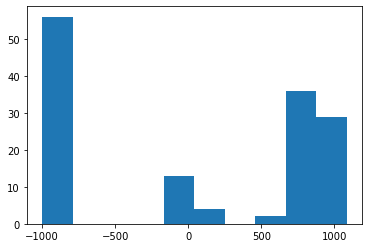

In [40]:
plt.hist([-1000 if item == 0 else item for item in [len(x) for x in indices_list]])
#plt.xscale('log')

In [27]:
abc = [len(x) for x in indices_list]

In [28]:
list(map(lambda x: x.replace(0, 256), abc))

AttributeError: 'int' object has no attribute 'replace'

In [20]:
pd.Series(best_var).value_counts()

0.000    56
0.010    38
0.001    29
0.500    13
0.100     4
dtype: int64

To beat (for 8,9): Correlation =  0.28751
Using drop-out NN: Correlation =  0.28178
Using 20000 points for millipede: Correlation = 0.284..

In [56]:
y_train[:,8:10]

matrix([[-0.6766891 , -0.49027386],
        [-0.41674453, -0.6901382 ],
        [-0.33195946, -0.7168782 ],
        ...,
        [-0.01302799, -0.5808464 ],
        [-0.1509006 , -0.56269693],
        [-0.48259225, -0.6310826 ]], dtype=float32)

In [2]:
X_train = scipy.sparse.load_npz('./sparse/train_cite_inputs_values.sparse.npz')
to_drop = np.genfromtxt("./sparse/drop_ids.csv", delimiter=',', dtype = int)
X_train = delete_columns_csr(X_train,to_drop)
X_train = X_train.toarray()
X_test = scipy.sparse.load_npz('./sparse/test_cite_inputs_values.sparse.npz')
X_test = delete_columns_csr(X_test,to_drop)
X_test = X_test.toarray()
y_train = scipy.sparse.load_npz('./sparse/train_cite_targets_values.sparse.npz')
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
y_train -= y_train.mean(axis=1).reshape(-1, 1)
y_train /= y_train.std(axis=1).reshape(-1, 1)
!pip install git+https://github.com/BasisResearch/millipede.git
from millipede import NormalLikelihoodVariableSelector
X_train_pca = np.genfromtxt('./pca64/X_train_64.csv',delimiter = ',')
X_train_mod = np.hstack([X_train,X_train_pca])   
X_train_mod -= X_train_mod.mean(axis=1).reshape(-1, 1)
X_train_mod /= X_train_mod.std(axis=1).reshape(-1, 1)
X_test_pca = np.genfromtxt('./pca64/X_test_64.csv',delimiter = ',')
X_test_mod = np.hstack([X_test,X_test_pca])   
X_test_mod -= X_test_mod.mean(axis=1).reshape(-1, 1)
X_test_mod /= X_test_mod.std(axis=1).reshape(-1, 1)
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)

  Cloning https://github.com/BasisResearch/millipede.git to /tmp/pip-req-build-eqc5uo66
  Running command git clone --filter=blob:none --quiet https://github.com/BasisResearch/millipede.git /tmp/pip-req-build-eqc5uo66
  Resolved https://github.com/BasisResearch/millipede.git to commit ecafe4194e216846600ff4f87dc02f65ce4428e2
  Preparing metadata (setup.py) ... done
  Using cached polyagamma-1.3.2-cp39-cp39-manylinux_2_12_x86_64.manylinux_2_5_x86_64.manylinux1_x86_64.manylinux2010_x86_64.whl (523 kB)
  Created wheel for millipede: filename=millipede-0.1.0-py3-none-any.whl size=33845 sha256=b291064f12ded2d659c6f24ce942f2bb411102173306fdb2a8baf28de520dbaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-c5i10hnv/wheels/0a/6b/57/40b20d03468593c7819cb14105caeb501b22dc304ff2f9193c
Successfully built millipede


In [4]:
y_pred = np.genfromtxt('./temp/y_pred_save_140.csv')
# catboost = pd.read_csv('./catboost/submission.csv',index_col='row_id', squeeze=True)
# catboost.iloc[:6812820] = test_cite_pred.ravel()
cell_ids = pd.read_parquet('./sparse/evaluation.parquet').cell_id

In [5]:
cell_ids

0           c2150f55becb
1           c2150f55becb
2           c2150f55becb
3           c2150f55becb
4           c2150f55becb
                ...     
65744175    2c53aa67933d
65744176    2c53aa67933d
65744177    2c53aa67933d
65744178    2c53aa67933d
65744179    2c53aa67933d
Name: cell_id, Length: 65744180, dtype: object

In [11]:
y_pred = np.genfromtxt('./temp/y_pred_save_9.csv')
pd.Series(y_pred)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
48658   NaN
48659   NaN
48660   NaN
48661   NaN
48662   NaN
Length: 48663, dtype: float64

In [ ]:
import os
!pip install kaggle
os.environ['KAGGLE_USERNAME'] = 'alexroberts'
os.environ['KAGGLE_KEY'] = 'eef5d3edec2428c7d4f14efcdb3f13ca'

!kaggle competitions submit -c open-problems-multimodal -f submit.zip -m 'multiome_ensemble_notebook_plus_own_cite_model'

In [29]:
def my_model(n_inputs,n_outputs,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(16,
              activation=activation,
             )(inputs)
    x1 = Dense(16,
              activation=activation,
             )(x0)
    x2 = Dense(16,
              activation=activation,
             )(x1)
    x3 = Dense(16,
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs,
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

# best_hp = keras_tuner.HyperParameters()
# best_hp.values = {'reg1': 1e-06,
#                   'reg2': 1.3528e-07,
#                   'units1': 256,
#                   'units2': 320,
#                   'units3': 256,
#                   'units4': 320,
#                   'do1': 0.1,
#                   'do2': 0.2,
#                   'do3': 0.2,
#                   'do4': 0.1,
#                   'do5': 0.1,
#                   'lr': 0.01,
#                  }

# def my_model(hp,n_inputs,n_outputs, loss):
#     """Sequential neural network
    
#     Returns a compiled instance of tensorflow.keras.models.Model.
#     """
#     activation = hp.Choice('act',['swish','selu'])
#     reg1 = hp.Float("reg1", min_value=1e-10, max_value=1e-6, sampling="log")
#     reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-6, sampling="log")
    
#     inputs = Input(shape=(n_inputs, ))
#     x0 = Dense(hp.Choice('units1', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(inputs)
#     do1 = Dropout(hp.Choice('do1', [0.1]))(x0)
#     x1 = Dense(hp.Choice('units2', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do1)
#     do2 = Dropout(hp.Choice('do2', [0.2]))(x1)
#     x2 = Dense(hp.Choice('units3', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do2)
#     do3 = Dropout(hp.Choice('do3', [0.2]))(x2)
#     x3 = Dense(hp.Choice('units4', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do3)
#     do4 = Dropout(hp.Choice('do4', [0.1]))(x3)
#     x = Concatenate()([x0, x1, x2, x3])
#     do5 = Dropout(hp.Choice('do5', [0.1]))(x)
#     x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
#               #activation=activation,
#              )(do5)
#     regressor = Model(inputs, x)
#     regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', [0.1])),
#                       metrics=[loss],
#                       loss=loss
#                      )
    
#     return regressor

def eval_model(X_tr,y_tr,X_va,y_va,loss=tf.keras.losses.MeanSquaredError()):
        
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                          patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                      patience=12, 
                      verbose=0,
                      mode="min", 
                      restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    # Construct and compile the model
    model = my_model(n_inputs=X_tr.shape[1],n_outputs=1,loss = loss)

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    
    # We validate the model
    y_pred = model.predict(X_va, batch_size=X_va.shape[0])
    mse = tf.keras.losses.MeanSquaredError()(y_va, y_pred)
    #corrscore = correlation_score(y_va, y_pred)

    print(f"{es.stopped_epoch:3} epochs, mse =  {mse:.5f}")

    return model

# Cross-validation
VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 60
N_SPLITS = 3
LR_START = 0.01
BATCH_SIZE = 256

def fit(X_train, y_train, X_test, meta):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]
        
        i_start = 0
        i_stop = 140
        indices = np.load('./temp/best_var_save_140.npy',allow_pickle=True)
        for i in np.arange(i_start,i_stop,1):
            print(i)
            indices_i = indices[i]
            if len(indices_i) == 0:
                model = eval_model(X_tr[:,-256:],y_tr[:,i],X_va[:,-256:],y_va[:,i])
                if 'y_pred' in locals():
                    y_pred = np.hstack([y_pred,model.predict(X_test[:,-256:])])
                    y_va_pred = np.hstack([y_va_pred,model.predict(X_va[:,-256:])])
                else:
                    y_pred = model.predict(X_test[:,-256:])
                    y_va_pred = model.predict(X_va[:,-256:])
            else:
                model = eval_model(X_tr[:,indices_i],y_tr[:,i],X_va[:,indices_i],y_va[:,i])
                if 'y_pred' in locals():
                    y_pred = np.hstack([y_pred,model.predict(X_test[:,indices_i])])
                    y_va_pred = np.hstack([y_va_pred,model.predict(X_va[:,indices_i])])
                else:
                    y_pred = model.predict(X_test[:,indices_i])
                    y_va_pred = model.predict(X_va[:,indices_i])
            np.savetxt('./temp/new_y_pred_save.csv',y_pred,delimiter=',')
            np.savetxt('./temp/new_y_va_pred_save.csv',y_va_pred,delimiter=',')
        corrscore = correlation_score(y_va[:,i_start:i_stop], y_va_pred)
        print(f"Correlation =  {corrscore:.5f}")
        return y_va_pred, y_pred
    # Show overall score
#    print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

gc.collect()
y_va_pred, y_pred = fit(X_train_mod, y_train, X_test_mod, meta)

0
1/1 [==============================] - 0s 95ms/step
 18 epochs, mse =  0.12985
776/776 [==============================] - 1s 2ms/step
1
1/1 [==============================] - 0s 89ms/step
 15 epochs, mse =  0.06687
776/776 [==============================] - 1s 2ms/step
2
1/1 [==============================] - 0s 88ms/step
 14 epochs, mse =  0.06805
776/776 [==============================] - 1s 2ms/step
3
1/1 [==============================] - 0s 77ms/step
 13 epochs, mse =  0.27684
776/776 [==============================] - 1s 2ms/step
4
1/1 [==============================] - 0s 76ms/step
 21 epochs, mse =  0.16228
776/776 [==============================] - 1s 2ms/step
5
1/1 [==============================] - 0s 79ms/step
 21 epochs, mse =  0.53813
776/776 [==============================] - 1s 2ms/step
6
1/1 [==============================] - 0s 76ms/step
 16 epochs, mse =  0.63024
776/776 [==============================] - 1s 2ms/step
7
1/1 [==============================] - 0s 87ms

In [ ]:
def my_model(n_inputs,n_outputs,loss):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'

    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(16,
              activation=activation,
             )(inputs)
    x1 = Dense(16,
              activation=activation,
             )(x0)
    x2 = Dense(16,
              activation=activation,
             )(x1)
    x3 = Dense(16,
              activation=activation,
             )(x2)
    x = Concatenate()([x0, x1, x2, x3])
    x = Dense(n_outputs,
              #activation=activation,
             )(x)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[loss],
                      loss=loss
                     )
    
    return regressor

# best_hp = keras_tuner.HyperParameters()
# best_hp.values = {'reg1': 1e-06,
#                   'reg2': 1.3528e-07,
#                   'units1': 256,
#                   'units2': 320,
#                   'units3': 256,
#                   'units4': 320,
#                   'do1': 0.1,
#                   'do2': 0.2,
#                   'do3': 0.2,
#                   'do4': 0.1,
#                   'do5': 0.1,
#                   'lr': 0.01,
#                  }

# def my_model(hp,n_inputs,n_outputs, loss):
#     """Sequential neural network
    
#     Returns a compiled instance of tensorflow.keras.models.Model.
#     """
#     activation = hp.Choice('act',['swish','selu'])
#     reg1 = hp.Float("reg1", min_value=1e-10, max_value=1e-6, sampling="log")
#     reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-6, sampling="log")
    
#     inputs = Input(shape=(n_inputs, ))
#     x0 = Dense(hp.Choice('units1', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(inputs)
#     do1 = Dropout(hp.Choice('do1', [0.1]))(x0)
#     x1 = Dense(hp.Choice('units2', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do1)
#     do2 = Dropout(hp.Choice('do2', [0.2]))(x1)
#     x2 = Dense(hp.Choice('units3', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do2)
#     do3 = Dropout(hp.Choice('do3', [0.2]))(x2)
#     x3 = Dense(hp.Choice('units4', [0.1]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
#               activation=activation,
#              )(do3)
#     do4 = Dropout(hp.Choice('do4', [0.1]))(x3)
#     x = Concatenate()([x0, x1, x2, x3])
#     do5 = Dropout(hp.Choice('do5', [0.1]))(x)
#     x = Dense(n_outputs, kernel_regularizer=tf.keras.regularizers.l2(reg2),
#               #activation=activation,
#              )(do5)
#     regressor = Model(inputs, x)
#     regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', [0.1])),
#                       metrics=[loss],
#                       loss=loss
#                      )
    
#     return regressor

def eval_model(X_tr,y_tr,X_va,y_va,loss=tf.keras.losses.MeanSquaredError()):
        
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                          patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                      patience=12, 
                      verbose=0,
                      mode="min", 
                      restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    # Construct and compile the model
    model = my_model(n_inputs=X_tr.shape[1],n_outputs=1,loss = loss)

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    
    # We validate the model
    y_pred = model.predict(X_va, batch_size=X_va.shape[0])
    mse = tf.keras.losses.MeanSquaredError()(y_va, y_pred)
    #corrscore = correlation_score(y_va, y_pred)

    print(f"{es.stopped_epoch:3} epochs, mse =  {mse:.5f}")

    return model

# Cross-validation
VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 60
N_SPLITS = 3
LR_START = 0.01
BATCH_SIZE = 256

def fit(X_train, y_train, X_test, meta):
    np.random.seed(1)
    tf.random.set_seed(1)

    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()
        X_tr = X_train[idx_tr]
        y_tr = y_train[idx_tr]
        X_va = X_train[idx_va]
        y_va = y_train[idx_va]
        
        i_start = 0
        i_stop = 140
        for i in np.arange(i_start,i_stop,1):
            print(i)
            model = eval_model(X_tr[:,-256:],y_tr[:,i],X_va[:,-256:],y_va[:,i])
            if 'y_pred' in locals():
                y_pred = np.hstack([y_pred,model.predict(X_test[:,-256:])])
                y_va_pred = np.hstack([y_va_pred,model.predict(X_va[:,-256:])])
            else:
                y_pred = model.predict(X_test[:,-256:])
                y_va_pred = model.predict(X_va[:,-256:])
            np.savetxt('./temp/only_pca_y_pred_save.csv',y_pred,delimiter=',')
        corrscore = correlation_score(y_va[:,i_start:i_stop], y_va_pred)
        print(f"Correlation =  {corrscore:.5f}")
        return y_va_pred, y_pred
    # Show overall score
#    print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

gc.collect()
y_va_pred, y_pred = fit(X_train_mod, y_train, X_test_mod, meta)

0


2022-10-20 20:43:48.029267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 20:43:48.030201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-20 20:43:48.030222: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-20 20:43:48.030491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

1/1 [==============================] - 0s 113ms/step
 21 epochs, mse =  0.12506
776/776 [==============================] - 1s 2ms/step
1
1/1 [==============================] - 0s 86ms/step
 16 epochs, mse =  0.06740
776/776 [==============================] - 1s 2ms/step
2
1/1 [==============================] - 0s 86ms/step
 19 epochs, mse =  0.06852
776/776 [==============================] - 1s 2ms/step
3
1/1 [==============================] - 0s 77ms/step
 14 epochs, mse =  0.27833
776/776 [==============================] - 1s 2ms/step
4
1/1 [==============================] - 0s 86ms/step
 24 epochs, mse =  0.16621
776/776 [==============================] - 1s 2ms/step
5
1/1 [==============================] - 0s 87ms/step
 22 epochs, mse =  0.53212
776/776 [==============================] - 1s 2ms/step
6
1/1 [==============================] - 0s 79ms/step
 16 epochs, mse =  0.63213
776/776 [==============================] - 1s 2ms/step
7
1/1 [==============================] - 0s 78ms/

In [ ]:
np.savetxt('./temp/only_pca_y_va_pred_save.csv',y_va_pred,delimiter=',')


In [5]:
print(1)

1


In [6]:
np.savetxt('./temp/only_pca_y_va_pred_save.csv',y_va_pred,delimiter=',')


In [8]:
y_va_pred.shape

(24803, 140)

In [9]:
np.random.seed(1)
tf.random.set_seed(1)

kf = GroupKFold(n_splits=N_SPLITS)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train, groups=meta.donor)):
    
    y_va = y_train[idx_va]

    corrscore = correlation_score(y_va, y_va_pred)
    print(f"Correlation =  {corrscore:.5f}")
    break

Correlation =  0.88877
